In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import gensim
from IPython.display import display
import re
import seaborn as sns
import random
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.porter import PorterStemmer
import spacy
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split


grid = {'n_estimators':      [50, 60, 80],
          'min_samples_leaf': [2, 4, 7, 10],
          'min_samples_split': [3, 5, 7, 9]}

/Users/Felix/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Felix/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Please note: Normally, we would use all word vectors (and ignore the `limit` parameter). However, I limited the number of used vectors because my current Laptop has very little RAM.

In [26]:
model = gensim.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', limit=1200000, binary=True)  

data = pd.read_csv("data/mbti.csv")
display(data)

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...
5,INTJ,'18/37 @.@|||Science is not perfect. No scien...
6,INFJ,"'No, I can't draw on my own nails (haha). Thos..."
7,INTJ,'I tend to build up a collection of things on ...
8,INFJ,"I'm not sure, that's a good question. The dist..."
9,INTP,'https://www.youtube.com/watch?v=w8-egj0y8Qs||...


In [3]:
def get_types():
    types = dict()
    types["extro"] = data[data["type"].astype(str).str[0] == "E"]
    types["intro"] = data[data["type"].astype(str).str[0] == "I"]
    types["intu"] = data[data["type"].astype(str).str[1]  == "N"]
    types["sens"] = data[data["type"].astype(str).str[1]  == "S"]
    types["thnk"] = data[data["type"].astype(str).str[2]  == "T"]
    types["feel"] = data[data["type"].astype(str).str[2]  == "F"]
    types["prcp"] = data[data["type"].astype(str).str[3]  == "P"]
    types["judg"] = data[data["type"].astype(str).str[3]  == "J"]
    return types

In [4]:
types = get_types()
for t in types:
    print("{}:\t{}".format(t, len(types[t])))

extro:	1999
intro:	6676
intu:	7478
sens:	1197
thnk:	3981
feel:	4694
prcp:	5241
judg:	3434


In [14]:
def draw_pie_chart(type1, type2, label1, label2):
    labels = [label1, label2]
    sizes = [len(types[type1]), len(types[type2])]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()

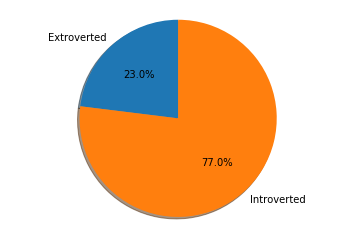

In [15]:
draw_pie_chart("extro", "intro", "Extroverted", "Introverted")

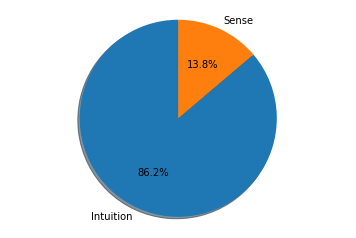

In [16]:
draw_pie_chart("intu", "sens", "Intuition", "Sense")

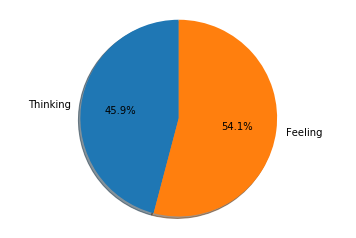

In [17]:
draw_pie_chart("thnk", "feel", "Thinking", "Feeling")

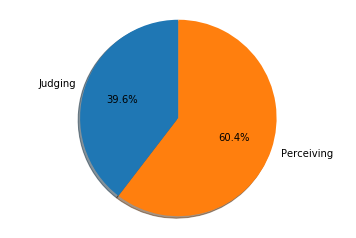

In [19]:
draw_pie_chart("judg", "prcp", "Judging", "Perceiving")

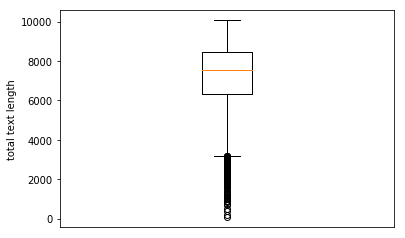

In [20]:
lengths = list(data.posts.apply(len))
plt.boxplot(lengths)
plt.ylabel("total text length")
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.show()

In [30]:
median_length = np.median(lengths)
mean_length   = np.mean(lengths)
percentiles = np.percentile(lengths, [75, 25])
l_short = percentiles[1] - 1.5 * (percentiles[0] - percentiles[1])
n_short = len(list(filter(lambda l: l < l_short, lengths)))
print(mean_length)
print(median_length)
print(l_short)
print(n_short)
print(len(lengths))

7234.98962536
7515.0
3169.0
179
8675


We will treat the users that wrote the least as outliers and remove them from our dataset. Having very little text for a user could decrease the quality of several features that we are going to use in furter steps.

8496


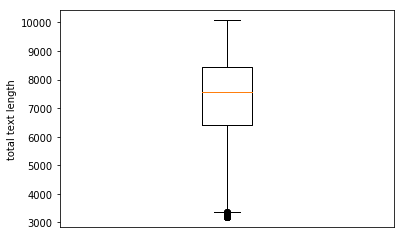

In [32]:
data = data[data.posts.apply(len) >= l_short]
print(len(data))

lengths = list(data.posts.apply(len))
plt.boxplot(lengths)
plt.ylabel("total text length")
plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
plt.show()

In [33]:
types = get_types()
for t in types:
    print("{}:\t{}".format(t, len(types[t])))

extro:	1957
intro:	6539
intu:	7342
sens:	1154
thnk:	3891
feel:	4605
prcp:	5132
judg:	3364


Now, we define several functions that will be of use in later steps. `is_w2v_word` tests whether a word is available in the word2vec vectors that we have access to. These words can be assumed to be the most frequent English words. `normalize_text` removes special characters from text. If `remove_unknown` is set to `True`, also words that are not represented by an available word2vec vector will be deleted from the text. Moreover, from every post we will delete all mentions of Myers-Briggs personality types, to account for the possible pitfall of our models learning to predict mentioned personality types which will not be available under real world circumstances.

In [34]:
sw_english = stopwords.words("english")

non_alpha = re.compile('[^a-zA-Z\s\']')
ws = re.compile('[\s+]')
mb = re.compile('[IE][NS][TF][PJ]')

nlp = spacy.load("en")

def normalize_text(text, remove_unknown=False):
    text = text.replace('|||', ' ')
    text = non_alpha.sub('', text)
    if not remove_unknown:
        return text
    else:
        text = text.split(" ")
        ret = []
        for w in text:
            if is_w2v_word(w):
                ret.append(w)
        text = " ".join(ret)
        return text

def is_w2v_word(w):
    if mb.match(w):
        return False
    return w in model.wv



    Only loading the 'en' tokenizer.



## Preparing the training and testing data

We will now perform class balancing and split users, represented by their posts, in a training and a testing set for each of the four MBTI dimensions. The relative size of the testing data is $0.25$ in each case.

In [35]:
def balance(v1, v2):
    majority = v1
    minority = v2
    swap = False
    if len(v2) > len(v1):
        minority = v1
        majority = v2
        swap = True
    ret = random.sample(majority, len(minority)), minority
    if not swap:
        return ret
    else:
        return ret[1], ret[0]
    
def get_train_test_samples(samples, test_size=0.25):
    l = list(samples)
    n_test = int(len(samples) * test_size)
    random.seed(42)
    random.shuffle(l)
    return samples[n_test:], samples[:n_test]

In [36]:
e_posts, i_posts = balance(list(types["extro"]["posts"].values), list(types["intro"]["posts"].values))
n_posts, s_posts = balance(list(types["intu"]["posts"].values),  list(types["sens"]["posts"].values) )
t_posts, f_posts = balance(list(types["thnk"]["posts"].values),  list(types["feel"]["posts"].values) )
j_posts, p_posts = balance(list(types["judg"]["posts"].values),  list(types["prcp"]["posts"].values) )

e_train, e_test = get_train_test_samples(e_posts)
i_train, i_test = get_train_test_samples(i_posts)
n_train, n_test = get_train_test_samples(n_posts)
s_train, s_test = get_train_test_samples(s_posts)
t_train, t_test = get_train_test_samples(t_posts)
f_train, f_test = get_train_test_samples(f_posts)
j_train, j_test = get_train_test_samples(j_posts)
p_train, p_test = get_train_test_samples(p_posts)


ei_vectors = [e_train, e_test, i_train, i_test]
ns_vectors = [n_train, n_test, s_train, s_test]
tf_vectors = [t_train, t_test, f_train, f_test]
jp_vectors = [j_train, j_test, p_train, p_test]

Comparing two random users, it's obvious that even for a human observer it's not too easy to distinguish introverted from extroverted people. Similarly, we should not assume that it is trivial to make distinctions for any of the four personality dimensions.

In [37]:
i = random.randint(0, 1999)
print("Random integer is {}".format(i))
print(types["extro"]["posts"].values[i][:1000])
print(types["intro"]["posts"].values[i][:1000])

Random integer is 837
'Dhani Jones?      I don't know if anyone here has ever seen his show on Travel Channel? It was cancelled after two seasons, but it was a good show. If you've seen it, what do you think? ENFP? He's...|||Don't know this Amy lady, but I have watched Ghost Adventures. I think that Zak definitely seems like an Extrovert, but he seems much too silly and expressive in general to be an INTJ. he seems more...|||I don't know if anyone here has ever seen his show on Travel Channel? It was cancelled after two seasons, but it was a good show. If you've seen it, what do you think? ENFP? He's definitely...|||The E is a given, the T as well if you've seen him in interviews. He doesn't come across as emotional in any way. He always has been very into himself being seen and considered by others as a very...|||Funny show reminiscent of the Fresh Prince, who was a well known ENFP. Both King Boomer and Brady could be either ESFPs or ENFPs, thoughts?|||This thought came to me as I was

## Training classifiers based on Bag of Words features

We will now create our baseline models and some optimized classifiers that are able to derive personality traits from bag of words vectors.

In [38]:
stemmer = PorterStemmer()

def normalize_posts(posts):
    return [stemmer.stem(p) for p in [normalize_text(p.lower(), remove_unknown=True) for p in posts]]

We will not use all words even if they appear only once. To avoid having to work with data of extremely high dimensionality, we are going to remove the least frequent words from the beginning.

In [39]:
vocab = [w for w in (" ".join(normalize_posts(data.posts.values))).split(" ")]
c = Counter(vocab)
vocab = [w for w in c if c[w] > 500]
print(len(vocab))

1619


In [40]:
print(" ".join([w for w in list(vocab)[:200]]))

moments not top what has been the most experience in your life on for today may perc you last thing my friend posted his facebook before next day rest peace hello sorry hear it's only natural relationship be all time every moment existence try figure hard times as welcome stuff game set match at least minutes moving i don't mean them while sitting same maybe basically come up with three you've that each type or types want do would more than likely use given cognitive functions when left by things is indeed video good one note somewhat subjective am completely death any dear were favorite games growing are now current cool it too late sad there's someone out there everyone wait thought confidence was just within inner world other enjoy me can worry people will always around if you're into hey main social live conversations even then quickly really part from because this thread get high eat over something intellectual many sentence how could think b watching movies health class clearly n

In [41]:
cv = CountVectorizer(vocabulary=vocab)

def to_bow(posts, normalized=True):
    if not normalized:
        posts = normalize_posts(posts)
    return [v.toarray()[0] for v in cv.transform(posts)]

In [42]:
def transform_vectors(f, *vectors):
    if len(vectors) == 1:
        vectors = [v for v in vectors[0]]
    return [f(v) for v in vectors]

def create_vectors_labels(positive, negative):
    return positive + negative, [0 for _ in range(len(positive))] + [1 for _ in range(len(negative))]

In [43]:
bow_ei = transform_vectors(lambda v: to_bow(v, False), ei_vectors)
bow_ns = transform_vectors(lambda v: to_bow(v, False), ns_vectors)
bow_tf = transform_vectors(lambda v: to_bow(v, False), tf_vectors)
bow_jp = transform_vectors(lambda v: to_bow(v, False), jp_vectors)

### Creating baseline RF classifiers 

In [44]:
baseline_ei = RandomForestClassifier()
baseline_ei.fit(*create_vectors_labels(bow_ei[0], bow_ei[2]))
baseline_ns = RandomForestClassifier()
baseline_ns.fit(*create_vectors_labels(bow_ns[0], bow_ns[2]))
baseline_tf = RandomForestClassifier()
baseline_tf.fit(*create_vectors_labels(bow_tf[0], bow_tf[2]))
baseline_jp = RandomForestClassifier()
baseline_jp.fit(*create_vectors_labels(bow_jp[0], bow_jp[2]))

print(baseline_ei.score(*create_vectors_labels(bow_ei[1], bow_ei[3])))
print(baseline_ns.score(*create_vectors_labels(bow_ns[1], bow_ns[3])))
print(baseline_tf.score(*create_vectors_labels(bow_tf[1], bow_tf[3])))
print(baseline_jp.score(*create_vectors_labels(bow_jp[1], bow_jp[3])))

0.580777096115
0.560763888889
0.623456790123
0.542211652794


Most of the basline models are slightly better than a simple model choosing predicted classes arbitrarily (having performed balancing, we would then expect an accuracy of $0.5$). Interestingly, the baseline classifier for distinguishing _thinking_ from _feeling_ personality types performs better than the other classifiers and achieves an accuracy of $> 0.6$.

### Creating optimized Bag of Words classifiers

In [45]:
opt_bow_ei = GridSearchCV(RandomForestClassifier(), grid, verbose=5)
opt_bow_ei.fit(*create_vectors_labels(bow_ei[0], bow_ei[2]))
chosen_params = opt_bow_ei.best_estimator_.get_params()
print(chosen_params)
opt_bow_ns = RandomForestClassifier(**chosen_params)
opt_bow_ns.fit(*create_vectors_labels(bow_ns[0], bow_ns[2]))
opt_bow_tf = RandomForestClassifier(**chosen_params)
opt_bow_tf.fit(*create_vectors_labels(bow_tf[0], bow_tf[2]))
opt_bow_jp = RandomForestClassifier(**chosen_params)
opt_bow_jp.fit(*create_vectors_labels(bow_jp[0], bow_jp[2]))


print(opt_bow_ei.score(*create_vectors_labels(bow_ei[1], bow_ei[3])))
print(opt_bow_ns.score(*create_vectors_labels(bow_ns[1], bow_ns[3])))
print(opt_bow_tf.score(*create_vectors_labels(bow_tf[1], bow_tf[3])))
print(opt_bow_jp.score(*create_vectors_labels(bow_jp[1], bow_jp[3])))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.586735 -   1.5s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.599182 -   1.7s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.2s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.587935 -   1.5s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.7s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.607143 -   2.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.578732 -   1.9s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.609407 -   1.4s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.622449 -   1.9s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.619632 -   1.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.630879 -   2.0s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.608163 -   1.3s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5,

[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=0.611452 -   1.0s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.624490 -   1.2s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.605317 -   1.3s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.619632 -   1.1s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.612245 -   1.5s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.598160 -   1.5s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7,

[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.606122 -   0.8s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.620654 -   0.8s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.618609 -   0.8s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.613265 -   1.0s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.603272 -   1.0s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.609407 -   1.0s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=80 .......
[CV]  min_samples_leaf=10, min_samples_s

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  3.2min finished


{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.621676891616
0.657986111111
0.732510288066
0.609393579073


In [46]:
pca = PCA(n_components=350)
pca.fit(bow_ei[0] + bow_ei[1] + bow_ei[2] + bow_ei[3])

PCA(copy=True, iterated_power='auto', n_components=350, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [47]:
pca.explained_variance_ratio_.cumsum()[-1]

0.9031392638284903

Using 350 principal components, we can still explain about 90% of the variance contained wihtin the bag of words representations.

We are now going to examine whether applying PCA can improve classification results.

In [48]:
transformed_bow_ei = transform_vectors(lambda v: list(pca.transform(v)), bow_ei)

In [49]:
clf_bow_t = GridSearchCV(RandomForestClassifier(), grid, verbose=5)
clf_bow_t.fit(*create_vectors_labels(transformed_bow_ei[0], transformed_bow_ei[2]))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.539796 -   1.9s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.549080 -   1.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.7s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.533742 -   1.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.5s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.583673 -   2.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.7s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.528630 -   2.2s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.553170 -   2.2s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.564286 -   3.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.573620 -   2.9s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.548057 -   2.8s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.553061 -   1.8s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5,

[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=0.567485 -   1.7s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.566327 -   2.1s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.591002 -   2.2s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.555215 -   2.1s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.597959 -   2.8s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.564417 -   2.7s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7,

[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.601020 -   1.5s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.581800 -   1.5s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.544990 -   1.5s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.590816 -   1.9s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.596115 -   1.8s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.588957 -   2.7s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=80 .......
[CV]  min_samples_leaf=10, min_samples_s

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  5.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 60, 80], 'min_samples_leaf': [2, 4, 7, 10], 'min_samples_split': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=5)

In [50]:
print(clf_bow_t.score(*create_vectors_labels(transformed_bow_ei[1], transformed_bow_ei[3])))

0.569529652352


Applying PCA to the BOW features did not lead to a significantly better performance; in fact, it led to a decrease in classification accuracy. Hence, we will stick to the classifiers using untransformed features.

## Identifying the most distinctive words

In [51]:
inverse_vocab = {v: k for k, v in cv.vocabulary_.items()}

def show_important_words(estimator, name):
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]

    n_words = 9
    
    words = [inverse_vocab[w] for w in indices]
    plt.figure()
    plt.title(name)
    plt.bar(range(n_words), importances[indices][:n_words], align="center")
    plt.xticks(range(n_words), [inverse_vocab[i] for i in indices])    
    plt.show()

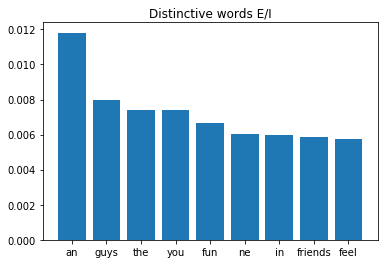

In [52]:
show_important_words(opt_bow_ei.best_estimator_, "Distinctive words E/I")

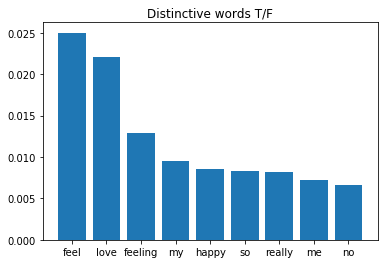

In [53]:
show_important_words(opt_bow_tf, "Distinctive words T/F")

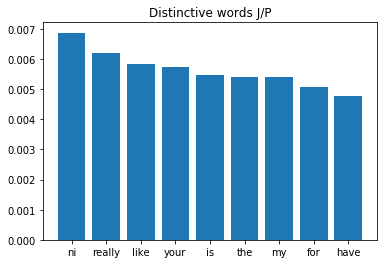

In [54]:
show_important_words(opt_bow_jp, "Distinctive words J/P")

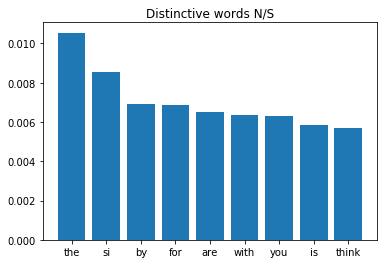

In [55]:
show_important_words(opt_bow_ns, "Distinctive words N/S")

## Using Principal Component Analysis (PCA) for Word2Vec Visualization

In [56]:
def create_w2v_vector(text):
    text = normalize_text(text)
    vector = [0 for _ in range(300)]
    n_words = 0
    for w in ws.split(text):
        if w in sw_english:
            continue
        if is_w2v_word(w):
            n_words += 1
            vector += model.wv[w]
    vector = np.array(vector)
    if n_words > 0:
        vector = np.divide(vector, n_words)
    return vector

In [57]:
pca = PCA(n_components=2)
w2v_ei = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], ei_vectors)
pca.fit(w2v_ei[0] + w2v_ei[1] + w2v_ei[2] + w2v_ei[3])

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [58]:
print(pca.explained_variance_ratio_)

[ 0.20775973  0.10679508]


In [59]:
intro_mean = np.mean(w2v_ei[0], axis=0)
extro_mean = np.mean(w2v_ei[2], axis=0)

In [67]:
x_intro = [ti[0] for ti in w2v_ei[0][:300]]
y_intro = [ti[1] for ti in w2v_ei[0][:300]]
x_extro = [te[0] for te in w2v_ei[2][:300]]
y_extro = [te[1] for te in w2v_ei[2][:300]]

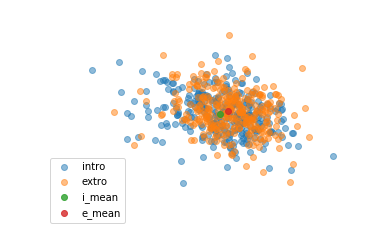

In [68]:
fig, ax = plt.subplots()
plt.scatter(x_intro, y_intro, label="intro", alpha=0.5)
plt.scatter(x_extro, y_extro, label="extro", alpha=0.5)
plt.scatter(intro_mean[0], intro_mean[1], label="i_mean", alpha=0.8)
plt.scatter(extro_mean[0], extro_mean[1], label="e_mean", alpha=0.8)
ax.axis('off')
ax.legend()

The plot does not really look promising. However, we have to keep in mind that the two displayed principal components account for only $\frac{1}{3}$ of the total variance in the available person vectors.

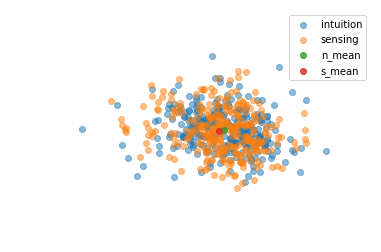

In [69]:
w2v_ns = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], ns_vectors)
x_n = [t[0] for t in w2v_ns[0][:300]]
y_n = [t[1] for t in w2v_ns[0][:300]]
x_s = [t[0] for t in w2v_ns[2][:300]] 
y_s = [t[1] for t in w2v_ns[2][:300]]
n_mean = np.mean(w2v_ns[0], axis=0)
s_mean = np.mean(w2v_ns[2], axis=0)


fig, ax = plt.subplots()
plt.scatter(x_n, y_n, label="intuition", alpha=0.5)
plt.scatter(x_s, y_s, label="sensing", alpha=0.5)
plt.scatter(n_mean[0], n_mean[1], label="n_mean", alpha=0.8)
plt.scatter(s_mean[0], s_mean[1], label="s_mean", alpha=0.8)
ax.axis('off')
ax.legend()

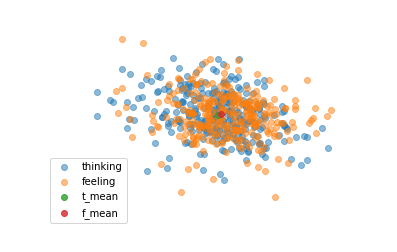

In [70]:
w2v_tf = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], tf_vectors)
x_t = [t[0] for t in w2v_tf[0][:300]]
y_t = [t[1] for t in w2v_tf[0][:300]]
x_f = [t[0] for t in w2v_tf[2][:300]] 
y_f = [t[1] for t in w2v_tf[2][:300]]
t_mean = np.mean(w2v_tf[0], axis=0)
f_mean = np.mean(w2v_tf[2], axis=0)

fig, ax = plt.subplots()
plt.scatter(x_t, y_t, label="thinking", alpha=0.5)
plt.scatter(x_f, y_f, label="feeling", alpha=0.5)
plt.scatter(t_mean[0], t_mean[1], label="t_mean", alpha=0.8)
plt.scatter(f_mean[0], f_mean[1], label="f_mean", alpha=0.8)
ax.axis('off')
ax.legend()

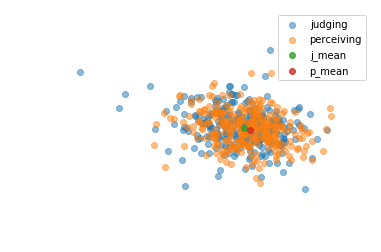

In [73]:
w2v_jp = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], jp_vectors)
x_j = [t[0] for t in w2v_jp[0][:300]]
y_j = [t[1] for t in w2v_jp[0][:300]]
x_p = [t[0] for t in w2v_jp[2][:300]] 
y_p = [t[1] for t in w2v_jp[2][:300]]
j_mean = np.mean(w2v_jp[0], axis=0)
p_mean = np.mean(w2v_jp[2], axis=0)

fig, ax = plt.subplots()
plt.scatter(x_j, y_j, label="judging", alpha=0.5)
plt.scatter(x_p, y_p, label="perceiving", alpha=0.5)
plt.scatter(j_mean[0], j_mean[1], label="j_mean", alpha=0.8)
plt.scatter(p_mean[0], p_mean[1], label="p_mean", alpha=0.8)
ax.axis('off')
ax.legend()

## Training classifiers using Word2Vec-based representations

In [65]:
w2v_ei = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], ei_vectors)
w2v_ns = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], ns_vectors)
w2v_tf = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], tf_vectors)
w2v_jp = transform_vectors(lambda v: [create_w2v_vector(p) for p in v], jp_vectors)

In [74]:
clf_ei_w2v = GridSearchCV(RandomForestClassifier(), grid, verbose=5)
clf_ei_w2v.fit(*create_vectors_labels(w2v_ei[0], w2v_ei[2]))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.634694 -   1.7s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.620654 -   1.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.634969 -   1.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.640816 -   2.4s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.8s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.609407 -   2.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.649284 -   2.2s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.642857 -   2.9s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.635992 -   3.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.671779 -   3.8s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.641837 -   2.1s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5,

[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=0.648262 -   2.1s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.625510 -   1.9s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.625767 -   1.8s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.648262 -   1.8s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.645918 -   2.3s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.625767 -   2.6s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7,

[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.616327 -   1.3s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.625767 -   1.3s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.666667 -   1.4s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.634694 -   2.5s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.645194 -   1.6s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.658487 -   1.6s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=80 .......
[CV]  min_samples_leaf=10, min_samples_s

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  5.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 60, 80], 'min_samples_leaf': [2, 4, 7, 10], 'min_samples_split': [3, 5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=5)

In [75]:
print(clf_ei_w2v.score(*create_vectors_labels(w2v_ei[1], w2v_ei[3])))
params = clf_ei_w2v.best_estimator_.get_params()

0.626789366053


We will assume that the same parameters can be applied to train RF classifiers for every of the four dimensions.

In [76]:
clf_ns_w2v = RandomForestClassifier(**params)
clf_ns_w2v.fit(*create_vectors_labels(w2v_ns[0], w2v_ns[2]))
print(clf_ns_w2v.score(*create_vectors_labels(w2v_ns[1], w2v_ns[3])))
      
clf_tf_w2v = RandomForestClassifier(**params)
clf_tf_w2v.fit(*create_vectors_labels(w2v_tf[0], w2v_tf[2]))
print(clf_tf_w2v.score(*create_vectors_labels(w2v_tf[1], w2v_tf[3])))
      
clf_jp_w2v = RandomForestClassifier(**params)
clf_jp_w2v.fit(*create_vectors_labels(w2v_jp[0], w2v_jp[2]))
print(clf_jp_w2v.score(*create_vectors_labels(w2v_jp[1], w2v_jp[3])))

0.65625
0.733024691358
0.605231866825


We now have four new classifiers. They seem to work slightly better than the classifiers trained on bag of words features.

The next step will examine whether applying PCA before training classifiers can improve performance.

In [77]:
pca = PCA(n_components=50)
pca.fit(w2v_jp[0] + w2v_jp[1] + w2v_jp[2] + w2v_jp[3])
print(pca.explained_variance_ratio_.cumsum()[-1])

0.800822243496


Dimensionality has been transformed to $\frac{1}{6}$ of the original size now, and still $80\%$ of the original variance are being explained by the transformed vectors.

In [78]:
transformed_w2v_ei = transform_vectors(lambda v: list(pca.transform(v)), w2v_ei)
clf_ei_w2v_t = GridSearchCV(RandomForestClassifier(), grid, verbose=5)
clf_ei_w2v_t.fit(*create_vectors_labels(transformed_w2v_ei[0], transformed_w2v_ei[2]))
print(clf_ei_w2v_t.score(*create_vectors_labels(transformed_w2v_ei[1], transformed_w2v_ei[3])))

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.639796 -   1.4s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.633947 -   0.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.631902 -   1.2s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.4s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.628571 -   1.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    4.5s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.638037 -   1.1s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.630879 -   1.0s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.639796 -   1.2s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.644172 -   1.2s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.640082 -   1.2s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.634694 -   0.8s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5,

[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=0.654397 -   0.8s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.635714 -   0.9s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.624744 -   0.9s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.653374 -   0.9s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.635714 -   1.1s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.635992 -   1.2s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7,

[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.645918 -   0.6s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.655419 -   0.7s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.638037 -   0.6s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.641837 -   0.7s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.638037 -   0.8s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.657464 -   0.8s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=80 .......
[CV]  min_samples_leaf=10, min_samples_s

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  2.4min finished


0.629856850716


Like in the case of BOW features, applying PCA did not lead to a significant improvement in accuracy.

## Training classifiers based on hand-crafted features

In [79]:
commonPos = ["PRON", "SPACE", "VERB", "ADV"]

def get_words_per_post(posts):
    p = posts.split("|||")
    complete = 0
    for post in p:
        complete += len(ws.split(post))
    return complete / len(p)

def get_posts_features(posts):
    n_posts = posts.count("|||") + 1
    wpp = get_words_per_post(posts)
    posts = posts.replace("|||", " ")
    doc = nlp(posts)
    counts = Counter([w.pos_ for w in doc if w.pos_ in commonPos])
    total = sum(counts.values(), 0.0)
    for key in counts:
        counts[key] /= total
    for apt in commonPos:
        if not apt in counts:
            counts[apt] = 0.
    ret = [counts[cp] for cp in commonPos]
    ret += [posts.count("http") / (n_posts)]
    ret += [posts.count("?") / (n_posts)]
    ret += [posts.count("!") / (n_posts)]
    ret += [posts.count(".") / (n_posts)]
    ret += [posts.count(":") / (n_posts)]
    ret += [wpp]
    return ret

def get_hcf_name(i):
    names = ["pron", "space", "verb", "adv", "http", "?", "!", ".", ":", "w/post"]
    return names[i]

In [80]:
hcf_ei = transform_vectors(lambda v: [get_posts_features(p) for p in v], ei_vectors)
hcf_ns = transform_vectors(lambda v: [get_posts_features(p) for p in v], ns_vectors)
hcf_tf = transform_vectors(lambda v: [get_posts_features(p) for p in v], tf_vectors)
hcf_jp = transform_vectors(lambda v: [get_posts_features(p) for p in v], jp_vectors)

In [81]:
print(np.mean(hcf_ei[0], axis=0))
print(np.mean(hcf_ei[2], axis=0))
print(np.abs(np.mean(hcf_ei[0], axis=0) - np.mean(hcf_ei[1], axis=0)))
print(np.std(hcf_ei[0], axis=0))
print(np.std(hcf_ei[2], axis=0))

[  0.30232563   0.26886949   0.25721063   0.17159425   0.05106856
   0.22988266   0.24115427   3.64925253   0.34111731  27.21596018]
[  0.29930996   0.26726452   0.25950511   0.1739204    0.06935284
   0.21476098   0.15692379   3.70677984   0.32246525  27.11921419]
[ 0.00701302  0.02107807  0.00748437  0.00658067  0.00141407  0.00521551
  0.01629874  0.06767861  0.01303679  0.2378585 ]
[ 0.1148587   0.18139111  0.07962848  0.08932995  0.09274968  0.13566398
  0.32782623  1.09015383  0.30526678  5.5166169 ]
[ 0.10623093  0.1798085   0.07861181  0.08135862  0.10827398  0.13054072
  0.19744099  1.04404883  0.28139819  5.66035392]


In [82]:
clf_ei_hcf = GridSearchCV(RandomForestClassifier(), grid, verbose=5)
clf_ei_hcf.fit(*create_vectors_labels(hcf_ei[0], hcf_ei[2]))
print(clf_ei_hcf.score(*create_vectors_labels(hcf_ei[1], hcf_ei[3])))
params = clf_ei_hcf.best_estimator_.get_params()

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.556122 -   0.4s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.567485 -   0.6s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.0s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.580777 -   0.5s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.539796 -   0.6s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.1s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.579755 -   0.6s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.576687 -   0.5s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.571429 -   0.7s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.572597 -   0.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.547035 -   0.7s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.534694 -   0.4s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5,

[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=0.561350 -   0.4s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.565306 -   0.4s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.589980 -   0.4s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.583845 -   0.4s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.546939 -   0.6s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.570552 -   0.6s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7,

[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.573469 -   0.4s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.582822 -   0.5s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.570552 -   0.6s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.570408 -   0.4s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.586912 -   0.4s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.575665 -   0.4s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=80 .......
[CV]  min_samples_leaf=10, min_samples_s

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  1.3min finished


0.539877300613


In [83]:
clf_ns_hcf = RandomForestClassifier(**params)
clf_ns_hcf.fit(*create_vectors_labels(hcf_ns[0], hcf_ns[2]))
print(clf_ns_hcf.score(*create_vectors_labels(hcf_ns[1], hcf_ns[3])))
      
clf_tf_hcf = RandomForestClassifier(**params)
clf_tf_hcf.fit(*create_vectors_labels(hcf_tf[0], hcf_tf[2]))
print(clf_tf_hcf.score(*create_vectors_labels(hcf_tf[1], hcf_tf[3])))
      
clf_jp_hcf = RandomForestClassifier(**params)
clf_jp_hcf.fit(*create_vectors_labels(hcf_jp[0], hcf_jp[2]))
print(clf_jp_hcf.score(*create_vectors_labels(hcf_jp[1], hcf_jp[3])))

0.512152777778
0.617798353909
0.52853745541


We now have four more classifiers that have been trained on hand-crafted features.

In [84]:
def create_importances_plot(estimator, name):
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]

    std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)    

    plt.figure()
    plt.title(name)
    plt.bar(range(10), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(10), [get_hcf_name(i) for i in indices])    
    plt.show()

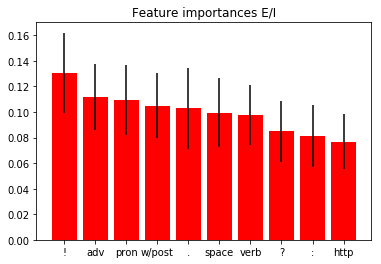

0.241154271422
0.156923794178
0.327826230718
0.197440990305


In [85]:
create_importances_plot(clf_ei_hcf.best_estimator_, "Feature importances E/I")
print(np.mean([e[6] for e in hcf_ei[0]]))
print(np.mean([i[6]  for i  in hcf_ei[2]]))
print(np.std([e[6] for e in hcf_ei[0]]))
print(np.std([i[6]  for i  in hcf_ei[2]]))

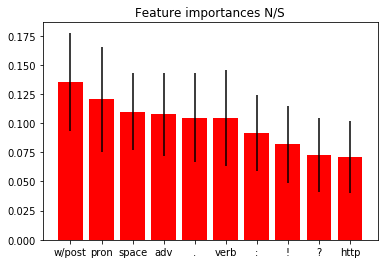

27.2137401095
26.3773220957
5.54256672774
6.01319188181


In [86]:
create_importances_plot(clf_ns_hcf, "Feature importances N/S")
print(np.mean([intu[9]  for intu  in hcf_ns[0]]))
print(np.mean([sens[9]  for sens  in hcf_ns[2]]))
print(np.std([intu[9]  for intu  in hcf_ns[0]]))
print(np.std([sens[9]  for sens  in hcf_ns[2]]))

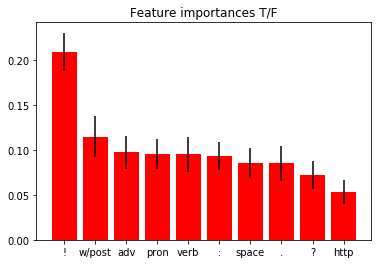

0.120777299428
0.218942606563
0.169163427516
0.27100899131


In [87]:
create_importances_plot(clf_tf_hcf, "Feature importances T/F")
print(np.mean([thinking[6] for thinking in hcf_tf[0]]))
print(np.mean([feeling[6]  for feeling  in hcf_tf[2]]))
print(np.std([thinking[6] for thinking in hcf_tf[0]]))
print(np.std([feeling[6]  for feeling  in hcf_tf[2]]))

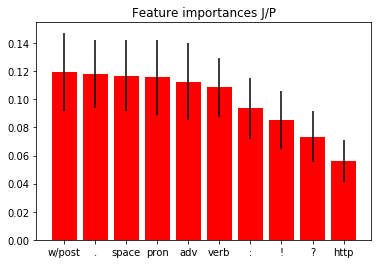

In [88]:
create_importances_plot(clf_jp_hcf, "Feature importances J/P")

## Using all features for classification

In [89]:
def combine_vectors(v1, v2, v3):
    p0 = [list(a) + list(b) + list(c) for a, b, c in zip(v1[0], v2[0], v3[0])]
    p1 = [list(a) + list(b) + list(c) for a, b, c in zip(v1[1], v2[1], v3[1])]
    p2 = [list(a) + list(b) + list(c) for a, b, c in zip(v1[2], v2[2], v3[2])]
    p3 = [list(a) + list(b) + list(c) for a, b, c in zip(v1[3], v2[3], v3[3])]

    return p0, p1, p2, p3


v_ei = combine_vectors(w2v_ei, bow_ei, hcf_ei)
v_tf = combine_vectors(w2v_tf, bow_tf, hcf_tf)
v_ns = combine_vectors(w2v_ns, bow_ns, hcf_ns)
v_jp = combine_vectors(w2v_jp, bow_jp, hcf_jp)

In [90]:
clf_ei_c = GridSearchCV(RandomForestClassifier(), grid, verbose=5)
clf_ei_c.fit(*create_vectors_labels(v_ei[0], v_ei[2]))
print(clf_ei_c.score(*create_vectors_labels(v_ei[1], v_ei[3])))
params = clf_ei_c.best_estimator_.get_params()

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.639796 -   2.7s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s



[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.627812 -   2.8s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=50 ........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.5s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=50, score=0.637014 -   3.5s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.0s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.622449 -   3.5s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   12.5s remaining:    0.0s


[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.645194 -   3.3s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=60 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=60, score=0.646217 -   3.3s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.621429 -   4.4s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.618609 -   4.2s
[CV] min_samples_leaf=2, min_samples_split=3, n_estimators=80 ........
[CV]  min_samples_leaf=2, min_samples_split=3, n_estimators=80, score=0.665644 -   4.0s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5, n_estimators=50, score=0.621429 -   2.4s
[CV] min_samples_leaf=2, min_samples_split=5, n_estimators=50 ........
[CV]  min_samples_leaf=2, min_samples_split=5,

[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=50, score=0.651329 -   3.1s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.629592 -   2.7s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.645194 -   3.2s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=60 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=60, score=0.652352 -   3.5s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.631633 -   4.2s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7, n_estimators=80, score=0.635992 -   4.8s
[CV] min_samples_leaf=4, min_samples_split=7, n_estimators=80 ........
[CV]  min_samples_leaf=4, min_samples_split=7,

[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.638776 -   2.0s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.634969 -   2.0s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=50 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=50, score=0.653374 -   2.1s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.638776 -   2.3s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.648262 -   2.2s
[CV] min_samples_leaf=10, min_samples_split=3, n_estimators=60 .......
[CV]  min_samples_leaf=10, min_samples_split=3, n_estimators=60, score=0.658487 -   2.2s
[CV] min_samples_leaf=10, min_samples_sp

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  6.9min finished


0.641104294479


In [101]:
print(params)

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [91]:
clf_ns_c = RandomForestClassifier(**params)
clf_ns_c.fit(*create_vectors_labels(v_ns[0], v_ns[2]))
print(clf_ns_c.score(*create_vectors_labels(v_ns[1], v_ns[3])))
      
clf_tf_c = RandomForestClassifier(**params)
clf_tf_c.fit(*create_vectors_labels(v_tf[0], v_tf[2]))
print(clf_tf_c.score(*create_vectors_labels(v_tf[1], v_tf[3])))
      
clf_jp_c = RandomForestClassifier(**params)
clf_jp_c.fit(*create_vectors_labels(v_jp[0], v_jp[2]))
print(clf_jp_c.score(*create_vectors_labels(v_jp[1], v_jp[3])))

0.670138888889
0.729423868313
0.617717003567


In [92]:
def print_most_characteristic(v, p1, p2, clf):
    '''
    prints the most characteristic posts for the two values of a personality dimension,
    based on the probability of our final classifier's results.
    '''
    argmax = np.argmax(clf.predict_proba(v[1]), axis=0)
    print(p1[argmax[0]])
    print("----------------------------------------------------")
    argmax = np.argmax(clf.predict_proba(v[3]), axis=0)
    print(p2[argmax[1]])    

Most characteristic extrovert vs. most characteristic introvert

In [93]:
print_most_characteristic(v_ei, e_test, i_test, clf_ei_c)

'so im an istp male - though my profile says estp.. Whatever... anyway, ive been in a relationship with an infp girl (CONFIRMED!!!! lol).  so its been a year and a hallf, my second longest...|||59734597355973659737:wink:|||I always have a blast, and constantly 'stir' the party. like, um . keeping it upbeat, Cause i get so talkative and it seems like everybody else is in slow motion :(    And then I wake up trying to...|||work smarter and not harder. take the N's job C:  Thus $60 every 10 min.|||still, the vague question is vague.|||like i was tryin to say|||You dont know what nig rig means? Or what, does that offend you? Like redneck-tech.,.. no ?  Lets just say its when you ducktape shit.|||Good C:|||you intuitives are CrAzY!|||Oh yea! Intersting point - i don't think least feminine means most masculine :/ eh?|||my vote is in esfj's And even more so on xsfp's|||like Miersho says, whats mbti got to do with it? But, for your sake; females wear that type well, as they do as sfp's, which 

Most characteristic intuitive vs. most characteristic sensing

In [94]:
print_most_characteristic(v_ns, n_test, s_test, clf_ns_c)

'taking both replies since... ..thanx for not being obnoxious TupidiPie, I'd say it is certain you do partake of the constructive and deconstructive act often as an intp. people don't understand...|||'right is right' right and so ufck fancy or grammatically correct|||..suggest this. work on throat charkra. in kundalini charkra system the throat has two granthis [/knots], so when in energy-visual-reminder exercises gets yin & yang energy to flow through the...|||This discussion could actually be continued within the Socionic Quadra framework. ...Lets say that outwardly media visible and party culture bias are dominated by Sensors and that culture-molding...|||most wouldn't believe this, 'manuals' are normally central reads, I believe Kant expanded on how to create models better from our thought ramages.|||at most knowing one's physiological - psychological - preference display type in the MTBI or Socionic Indicators is a rite of passage. Any internet fiend should pass through it, and it

Most characteristic thinking vs. most characteristic feeling

In [95]:
print_most_characteristic(v_tf, t_test, f_test, clf_tf_c)

Interesting, might be unrelated but I just happened to be watching a documentary BBC iPlayer - Horizon: 2011-2012: Do You See What I See? last night about colour. While I had read about it before it...|||You could always take a playboy (or equivalent) in with you and do a handstand. Of course you only have small time window with which to accomplish your task.|||Here's a simple conversation that will help you socialise.  You: I was reading about this tricky problem and I'm stuck with it. Him: What problem is that. You: (Describe some difficult problem...|||What evidence do you have to support that statement?|||But isn't your concept of God based on what is outlined in a book written by man (who can lie).|||Two that come to mind are Valhalla Rising, Crazy Eights.|||In work I do some computer modelling of various systems so having extra variety in the languages you know can allow you to speed up certain applications. Also if the uni I went to is anything to go...|||Hi, welcome to the craz

Most characteristic judging vs. most characteristic perceiving

In [96]:
print_most_characteristic(v_jp, j_test, p_test, clf_jp_c)

'I believe romantic attraction often causes INTJ's to get stuck in this loop, because Te verification can lead to rejection. In situations where things are ambiguous with the object of your affection,...|||I enjoy delivering lectures to large audiences, assuming I have had my requisite preparation time (a lot). That is because I know that I am giving a masterful delivery and using my abilities to make...|||This sounds like a new idea, and I'm curious how you see this. I hope you'll elaborate.|||Not a question (or a sentence).     An INTJ might be able to guess your feelings based on actions, but being told where you stand provides more certainty. When it comes to something as messy as...|||The notion that you have to love yourself at all times to be loved is obviously flawed. Say your partner came home, down on themselves for making a mistake. Would you stop loving them? Or would you...|||It seems the only thing we can say for sure is that your biggest problem was communication, in spi

'I cannot even begin to describe how screwed up everything in my life seems to be.  It would seem unseemly (lol) when on the outside, my life seems to be back on track after a rocky road to nowhere...|||Hey guys  I guess the last confessional thread was lost in the switch to this terrible stupid ugly ass layout?  Oh well the moderators never did know how to make a website look you know, normal or...|||I got J on the last test I took, and I'm INFP.  … Weird|||That show on MTV before 1g5g … it's like a redneck attempt at America's Funniest Home Videos, and just like that show, sucks ass. That new one with Zooey Deschannel in it … what's it called? ...|||hufflepuff.|||omg.  I can't believe I was on the internet for 3 hours ... without music.   http://i229.photobucket.com/albums/ee106/mandycide/tumblr_lunkwx4wDW1qziy6mo1_500.jpg|||what a scary picture in my mind.  ._. no, i mean its dysfunctional :P|||sometimes, my life feels like it resembles this video.    http://www.youtube.com/watch?v=

In [97]:
def get_all_classifications(vectors):
    i = sum(clf_ei_c.predict(vectors)) / len(vectors)
    f = sum(clf_tf_c.predict(vectors)) / len(vectors)
    s = sum(clf_ns_c.predict(vectors)) / len(vectors)
    p = sum(clf_jp_c.predict(vectors)) / len(vectors)
    return i, 1 - i, f, 1 - f, s, 1 - s, p, 1 - p

In [98]:
i, e, f, t, s, n, p, j = get_all_classifications(v_ei[1])
print(e)

0.627811860941


In [99]:
tpe = ['i', 'e', 'f', 't', 's', 'n', 'p', 'j'] * 8
true = []
for t in tpe[:8]:
    true += [t] * 8
    
value  = get_all_classifications(v_ei[3])
value += get_all_classifications(v_ei[1])
value += get_all_classifications(v_tf[3])
value += get_all_classifications(v_tf[1])
value += get_all_classifications(v_ns[3])
value += get_all_classifications(v_ns[1])
value += get_all_classifications(v_jp[3])
value += get_all_classifications(v_jp[1])

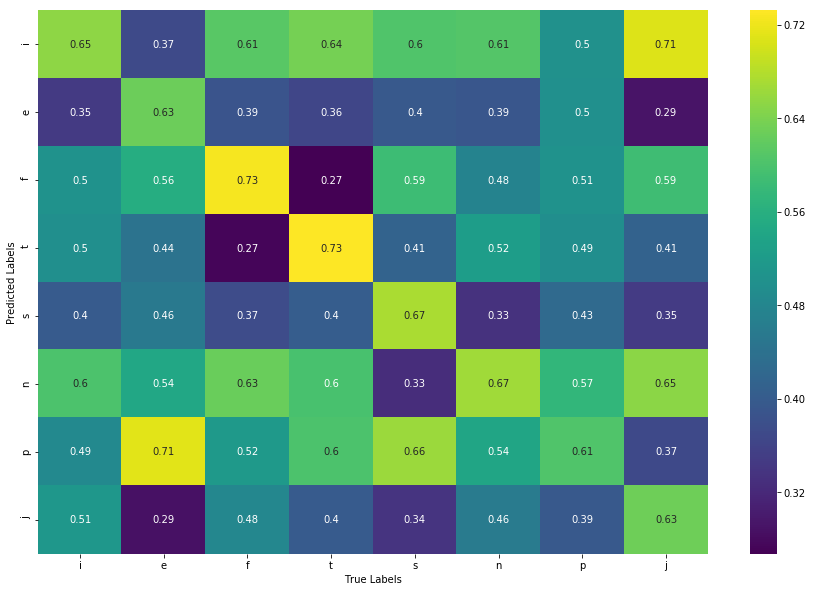

In [100]:
df = pd.DataFrame({'True Labels': true, 'Predicted Labels': tpe,  'value': value})



plt.figure(figsize=(15, 10))
result = df.pivot(index='Predicted Labels', columns='True Labels', values='value')
result = result.reindex(tpe[:8], axis=0)
result = result.reindex(tpe[:8], axis=1)


sns.heatmap(result, annot=True, cmap='viridis')
plt.show()